In [1]:
from imp_bojoy import atten
import math
from math import pi
import numpy as np
import matplotlib.pyplot as plt

#Create lenght of R to work on
r0=10e3
rmax=400e3
nsteps=1000 #number of steps
r=np.linspace(r0,rmax,nsteps,endpoint=True)

In [2]:
#equation for the behavior of V as a function of attenuation
beta=3000
f=5
omega=2*pi*f
kappa=0.04
vbehave=np.ones(r.size) # define as array of same size as r full of ones
vbehave=np.exp(omega*kappa/2+(omega*r/(2*beta*atten(f))))

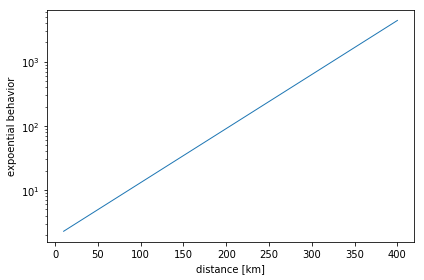

In [3]:
fig, ax1=plt.subplots()
ax1.set_xlabel('distance [km]')
ax1.set_ylabel('expoential behavior')
ax1.set_yscale('log')
ax1.plot(r/1000,vbehave,linewidth=1)
fig.tight_layout()
plt.show()

In [4]:
def id_nearest(array,value):      # reports index nearest value from array
    idx = (np.abs(array - value)).argmin()
    return idx
#freq_pos  = np.array(freq[:n // 2]) #//TODO Need to recreate this artificially (.003 in f?)
freq_pos = np.arange(.1,50,.03) #creating synthetic f-dist

/Users/anewman/anaconda3/lib/python3.7/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)
/Users/anewman/Documents/Projects/NukeDetection/Impedance/imp_bojoy.py:108: RuntimeWarning: divide by zero encountered in true_divide
  f=1./tp             # Frequency (have to put that factor of 4 back in..)


1153630.37953
1.44861075532e+20 2.12771947741e+27
15.318609579457002


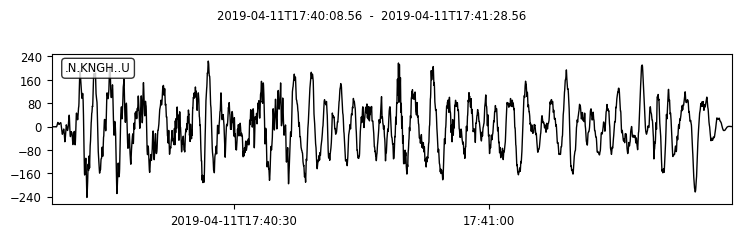

In [11]:
from imp_bojoy import imp_bojoy
from imp_bojoy import atten
from obspy import read
from obspy.geodetics import locations2degrees
from obspy.taup import TauPyModel
import math
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from imp_bojoy import g2geomsprd
import glob

def id_nearest(array,value):      # reports index nearest value from array
    idx = (np.abs(array - value)).argmin()
    return idx
#freq_pos  = np.array(freq[:n // 2]) #//TODO Need to recreate this artificially (.003 in f?)
freq_pos = np.arange(.1,50,.03) #creating synthetic f-dist

origlat=40.4191
origlong=143.3042
origdep=12.2
model= TauPyModel(model='iasp91')
density=2700
beta=3400
S=2
Signal_length=80
preP=20
Fs=np.sqrt(2/5)
ro=40000
#r=10000
kappa=0.04
k=kappa


#stream = read("N.TWWH.U.SAC") # sample file
stream = read("N.KNGH.U.SAC") # sample file  (TOO FAR)
#stream = read("N.IW2H.U.SAC") # sample file
tr=stream[0] # trace the stream

df = tr.stats.sampling_rate
stalat = tr.stats.sac.stla #coordinates.latitude
stalong = tr.stats.sac.stlo #coordinates.longitude
start_time = tr.stats.starttime #start of trace
# Find distance between station and event
distance_degrees_orig_to_station  = locations2degrees(origlat,origlong,stalat,stalong)
#Convert epicentral distance degrees to meters
dist_m = 6371000.*(pi/180)*distance_degrees_orig_to_station
# Find the predicted P-wave arrival time wrt the origin time (in seconds)
predict_arrival = model.get_travel_times(source_depth_in_km = origdep, distance_in_degree = distance_degrees_orig_to_station, phase_list=["P"])
# Need to get seconds (original output of the function above is the arrival time and the corresponding phase
pred_Parrival_time = predict_arrival[0].time
#print(pred_Parrival_time)
# Re-define start of trace predicted P-arrival and 60 seconds after
# Copy the traces! (To keep original data unchanged)
tr_copy = tr.copy()
tr_copy.trim(starttime=start_time+pred_Parrival_time-preP, endtime=start_time+pred_Parrival_time-preP+Signal_length) # 2 S pad for early P

# Remove Mean and Take Bandpass filter 1 to 10 Hz
tr_copy.detrend(type='demean')
# could detrend as well
tr_copy.filter(type='bandpass',freqmin=0.1,freqmax=10, corners=4, zerophase = True) # zerophase = True, apply filter once forwards and once backwards.This results in twice the filter order but zero phase shift in the resulting filtered trace
# Use HANN window Taper
# To get the same results as the default taper in SAC, use max_percentage=0.05 and leave type as hann.
tr_copy.taper(0.05,type='hann', max_length = None, side = 'both') # we're assuming the amount is per-side.
#convert velocity from nm/s to m/s
v = tr_copy.data/(1E+9)
# Take fft and convert to angular frequency (mult by 2pi)
# The abolute value of fft output gives the amplitude of the velocity spectrum (and only positive(realhalf))
nv = np.array(v).size
amplitude = abs((np.fft.fft(v)))[:nv // 2]

Vel_amp = amplitude # skipping instrument response for now..

#The fftfreq function generates a list of frequencies that correspond to the components of the Fourier transform.
# It gives $N$ values in the interval (-0.5,0.5).
# To convert to the actual frequency, you need to divide by the sampling interval in time.
dt = 1/df  #inverse of sampling rate
# We want to include only the positive half of the frequencies to define frequencies freq
freq = np.fft.fftfreq(nv, d=dt)
f = np.array(freq[:nv // 2])  # positive side of spectrum


fbounds=np.array([2,5])
fbids=np.zeros(fbounds.size)
fbids[0]=id_nearest(f,fbounds[0]) # nearest point on bottom end
fbids[1]=id_nearest(f,fbounds[1]) # top end
f_cut=np.array(f[int(fbids[0]):int(fbids[1])]) # create new finite frequency band to integrate over
amp_cut = np.array(Vel_amp[int(fbids[0]):int(fbids[1])])
ts = []
v_corr = []
r = np.sqrt((dist_m)**2 + (origdep*1000)**2)
#print(r)
for i in range(len(f_cut)):
      w = 2*pi*f_cut[i]
      Q = atten(f_cut[i]) # #atten_corr = atten(freq)check because it was written for frequency input but in equation is w
      tstar = r/(beta*Q)
      geo_corr = g2geomsprd(r,ro,f_cut[i])  #geo_corr = g2geomsprd(r,ro,freq)  ;  #imp_corr = imp_bojoy(w)
      #v_corr.append(np.exp((w*k*0.5) + ((w*tstar*.5)))) #*(geo_corr/(S*Fs))*fft_amp_cut[i]) 
      v_corr.append(np.sqrt((imp_bojoy(w)/(density*beta)))*np.exp((w*k*0.5) + ((w*tstar*.5)))
                    *(geo_corr/(S*Fs))*amp_cut[i])
v2 = (np.array(v_corr)**2)# square the corrected velocity power spectrum
integral = np.trapz(v2, dx=(df*2*pi))  # computes integral using Trapezoidal Rule
E = 4*density*beta*(Fs**2)*integral

from math import log, log10
print(dist_m)
print(integral,E)
print(2/3*log10(E)-2.9)
#tr_demean.plot()
plotout=tr_copy.plot()


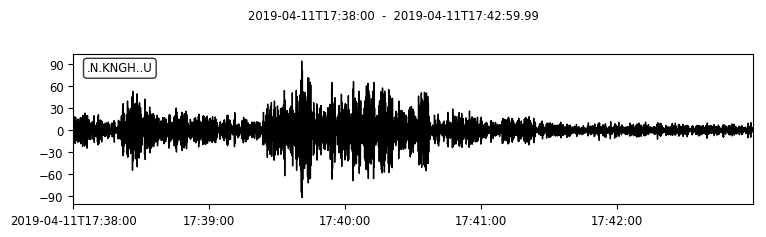

In [13]:
v_filt2 = tr.filter(type='bandpass',freqmin=2,freqmax=5, corners=4, zerophase = True)
plotout=v_filt2.plot()

In [10]:
print(f)

[  0.00000000e+00   1.24984377e-02   2.49968754e-02 ...,   4.99562555e+01
   4.99687539e+01   4.99812523e+01]


In [ ]:
f[0]=0.0001

In [ ]:
print(vbehave)